# kernel design

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
import torch.nn as nn
import cv2

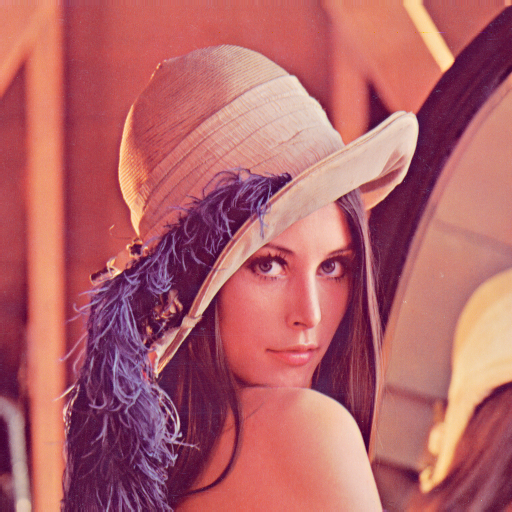

In [6]:
img = Image.open('../../../dataset/cvimages/LenaRGB.tif')
img

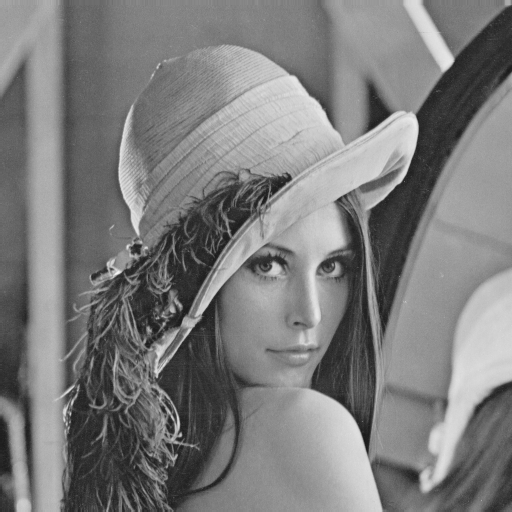

In [7]:
gray_image = transforms.Grayscale()(img)
gray_image

In [8]:
# 转换图片为 Tensor，缩放到 (224, 224)，并归一化
# Resize: 224这个归一化的标准有一定的历史原因
# Normalize: 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.224])
])

img_tensor = transform(gray_image)
img_tensor

tensor([[[ 0.6040,  0.5865,  0.5690,  ...,  0.6390,  0.7265,  0.3589],
         [ 0.6040,  0.5865,  0.5690,  ...,  0.6215,  0.7090,  0.3239],
         [ 0.6040,  0.5515,  0.5515,  ...,  0.1663, -0.0788, -0.5690],
         ...,
         [-1.3568, -1.3218, -1.3043,  ..., -0.9716, -0.7265, -0.6565],
         [-1.3918, -1.3568, -1.3568,  ..., -0.7265, -0.5340, -0.5340],
         [-1.4268, -1.3393, -1.3568,  ..., -0.5690, -0.4464, -0.3939]]])

在 PyTorch 中，`Normalize` 是图像预处理中的常见操作，通常用于标准化图像数据。`Normalize` 函数的参数决定了如何对图像的每个通道进行归一化，具体是通过均值和标准差来实现的。其作用是将图像的像素值变换为均值为 0、标准差为 1 的标准分布，以加快模型的收敛速度并提高模型的性能。

### `transforms.Normalize(mean, std)` 参数的意义
- **mean**：图像每个通道的均值，用于将该通道的像素值从原始范围中平移。
- **std**：图像每个通道的标准差，用于缩放该通道的像素值。

具体来说，对输入的图像，`Normalize` 的公式如下：

$$
\text{output} = \frac{\text{input} - \text{mean}}{\text{std}}
$$

其中 `input` 是图像的像素值，`mean` 和 `std` 分别是各个通道的均值和标准差。

### 举例
假设你有一个 RGB 图像，标准化的参数为：

```python
transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
```

这意味着图像的每个通道（红色、绿色、蓝色）的像素值会按以下公式进行处理：

$$
\text{output}_{\text{R}} = \frac{\text{input}_{\text{R}} - 0.5}{0.5}
$$
$$
\text{output}_{\text{G}} = \frac{\text{input}_{\text{G}} - 0.5}{0.5}
$$
$$
\text{output}_{\text{B}} = \frac{\text{input}_{\text{B}} - 0.5}{0.5}
$$

- **mean = [0.5, 0.5, 0.5]**：表示对每个通道的均值为 0.5 的像素值进行平移。
- **std = [0.5, 0.5, 0.5]**：表示对每个通道按 0.5 的标准差进行缩放。

这样，原始像素值在 [0, 1] 之间的范围会被标准化到 [-1, 1] 之间。这种归一化对于大多数神经网络模型（尤其是预训练模型）都有利于模型训练。

### 为什么需要 Normalize？
1. **加速模型训练**：标准化后的数据可以让模型更快收敛，因为它使得输入数据的尺度更统一。
2. **提升模型性能**：避免不同通道的数据值范围差异过大，有助于模型学到更有代表性的特征。
3. **适应预训练模型**：如果使用预训练模型，通常输入数据必须标准化为某种特定的均值和标准差（如 ImageNet 数据集上训练的模型常用 `[0.485, 0.456, 0.406]` 和 `[0.229, 0.224, 0.225]`）。

### 常用的标准化参数
- 对于 ImageNet 数据集，通常使用的均值和标准差为：

```python
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
```

这对应于 ImageNet 数据集中 RGB 三个通道的图像像素值分布。

In [9]:
img_tensor.size()

torch.Size([1, 224, 224])

## 正交检测、直角检测

### Sobel Operator

In [10]:
# 定义 Sobel 水平方向卷积核
sobel_kernel_x = torch.tensor([[-1.0, 0.0, 1.0],
                               [-2.0, 0.0, 2.0],
                               [-1.0, 0.0, 1.0]])

# 定义 Sobel 垂直方向卷积核
sobel_kernel_y = torch.tensor([[-1.0, -2.0, -1.0],
                               [0.0,  0.0,  0.0],
                               [1.0,  2.0,  1.0]])

# 将卷积核扩展为适用于 PyTorch 的格式 (out_channels, in_channels, kernel_size, kernel_size)
sobel_kernel_x = sobel_kernel_x.expand(1, 1, 3, 3)
sobel_kernel_y = sobel_kernel_y.expand(1, 1, 3, 3)

In [11]:
# 定义 Sobel 卷积层
class SobelConv(nn.Module):
    def __init__(self):
        super(SobelConv, self).__init__()
        # 将 Sobel 核定义为固定的卷积层权重
        self.conv_x = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
        self.conv_y = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1, bias=False)
        # 设置权重为 Sobel 核，并固定不更新
        self.conv_x.weight = nn.Parameter(sobel_kernel_x, requires_grad=False)
        self.conv_y.weight = nn.Parameter(sobel_kernel_y, requires_grad=False)

    def forward(self, x):
        # 使用水平方向和垂直方向的 Sobel 核卷积
        grad_x = self.conv_x(x)
        grad_y = self.conv_y(x)
        # 返回梯度的幅值
        grad = torch.sqrt(grad_x**2 + grad_y**2)
        return grad

In [12]:
# 定义 Sobel 算子的卷积核
sobel_x = torch.tensor([[-1., 0., 1.],
                        [-2., 0., 2.],
                        [-1., 0., 1.]]).view(1, 1, 3, 3)
sobel_x

tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])

In [13]:
sobel_y = torch.tensor([[-1., -2., -1.],
                        [0., 0., 0.],
                        [1., 2., 1.]]).view(1, 1, 3, 3)
sobel_y

tensor([[[[-1., -2., -1.],
          [ 0.,  0.,  0.],
          [ 1.,  2.,  1.]]]])

In [14]:
# 使用 Sobel 卷积核分别检测水平和垂直边缘
output_x = F.conv2d(img_tensor, sobel_x)
output_x.shape

torch.Size([1, 222, 222])

In [15]:
output_y = F.conv2d(img_tensor, sobel_y)
output_y.shape

torch.Size([1, 222, 222])

In [16]:
output = torch.sqrt(output_x**2 + output_y**2)

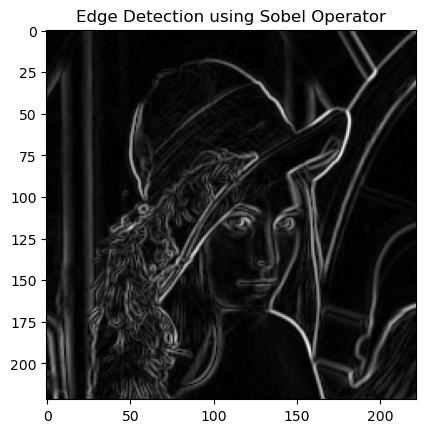

In [17]:
# 转换为 NumPy 格式并移除批次和通道维度
output_image_np = output.squeeze().detach().numpy()

# 绘制合并后的梯度幅值图像
plt.imshow(output_image_np, cmap='gray')
plt.title("Edge Detection using Sobel Operator")
plt.show()

## blur kernel

In [18]:
# 定义一个模糊卷积核
box_blur_kernel = torch.tensor([[1.0, 1.0, 1.0], 
                                [1.0, 1.0, 1.0], 
                                [1.0, 1.0, 1.0]]) / 9.0

In [19]:
gaussian_blur_kernel = torch.tensor([[1.0, 2.0, 1.0], 
                                     [2.0, 4.0, 2.0], 
                                     [1.0, 2.0, 1.0]]) / 16.0

In [20]:
# 将 kernel 扩展为 4D 张量，以用于 2D 卷积
box_blur_kernel = box_blur_kernel.expand(1, 1, 3, 3)
gaussian_blur_kernel = gaussian_blur_kernel.expand(1, 1, 3, 3)

In [21]:
# 定义模糊卷积层
class BlurConv(nn.Module):
    def __init__(self, kernel):
        super(BlurConv, self).__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        self.conv.weight = nn.Parameter(kernel, requires_grad=False)

    def forward(self, x):
        return self.conv(x)

In [22]:
# 创建模糊卷积层
box_blur_conv = BlurConv(box_blur_kernel)
gaussian_blur_conv = BlurConv(gaussian_blur_kernel)

In [23]:
output = box_blur_conv(img_tensor)
output.shape

torch.Size([1, 224, 224])

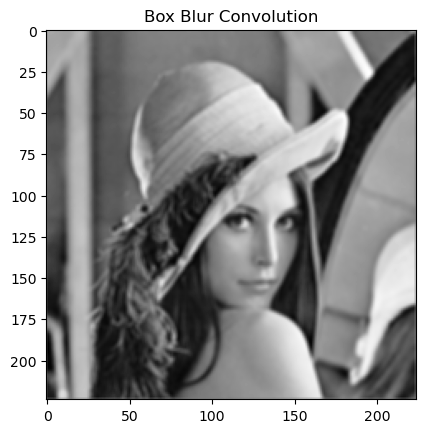

In [24]:
# 转换为 NumPy 格式并移除批次和通道维度
output_image_np = output.squeeze().detach().numpy()

# 绘制合并后的梯度幅值图像
plt.imshow(output_image_np, cmap='gray')
plt.title("Box Blur Convolution")
plt.show()

In [25]:
output = gaussian_blur_conv(img_tensor)
output.shape

torch.Size([1, 224, 224])

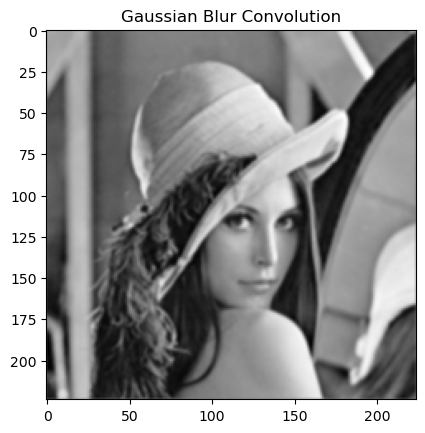

In [26]:
# 转换为 NumPy 格式并移除批次和通道维度
output_image_np = output.squeeze().detach().numpy()

# 绘制合并后的梯度幅值图像
plt.imshow(output_image_np, cmap='gray')
plt.title("Gaussian Blur Convolution")
plt.show()